# 1. Load Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
import time 
import pickle

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

**Note:** Using `RAF-DB`. Mapping from labels to emotions is as follows: 

```1="surprise", 2="fear", 3="disgust", 4="happiness", 5="sadness", 6="anger", 7="neutral"```

**Contents:** *"... containing 12271 training samples and 3068 testing samples..."* 

In [3]:
from data import load_rafdb
from data import RAF_DB_EMOTION_MAPPING

train_generator = load_rafdb("train")
validation_generator = load_rafdb("test")

Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


# 2. Examine the Dataset
**Note:** Once the data is labelled (for demographic attributes such as gender), we can also do data exploration in terms of the dataset balance, etc. 

In [4]:
data = train_generator.next()

Ground truth 3 = happiness


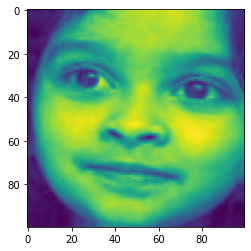

In [5]:
plt.imshow(data[0][0])
label = np.argmax(data[1][0])
print("Ground truth", label, "=", RAF_DB_EMOTION_MAPPING[label])

# 3. Defining the Model Architecture
Model architecture defined in Keras in `fer_model.py`. 

Architecture originally proposed by [Goodfellow et al., 2013](https://arxiv.org/pdf/1307.0414.pdf). 

In [6]:
from fer_model import get_fer_model

model = get_fer_model(input_size=100, input_channels=1, out_classes=7)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 128)       5

# 4. Training the Baseline Model 
Baseline here stands for the original, *un-compressed* version. Later we will apply compression strategies on top of it.

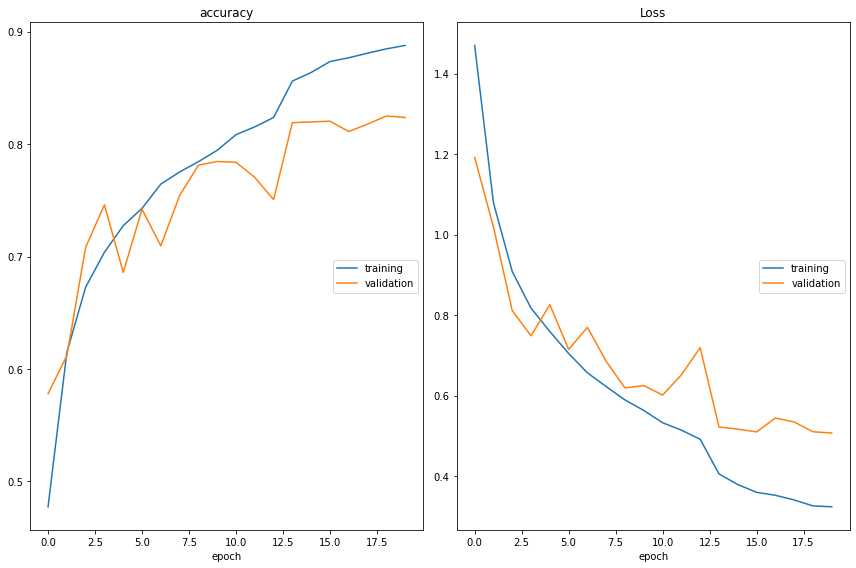

accuracy
	training         	 (min:    0.477, max:    0.888, cur:    0.888)
	validation       	 (min:    0.578, max:    0.825, cur:    0.824)
Loss
	training         	 (min:    0.324, max:    1.470, cur:    0.324)
	validation       	 (min:    0.507, max:    1.191, cur:    0.507)

Epoch 00020: val_accuracy did not improve from 0.82500
383/383 [==============================] - 876s 2s/step - loss: 0.3237 - accuracy: 0.8877 - val_loss: 0.5068 - val_accuracy: 0.8237
CPU times: user 11h 9min 25s, sys: 6min 17s, total: 11h 15min 43s
Wall time: 13h 22min 20s


In [7]:
%%time
TIMESTAMP = round(time.time())

epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("./weights_rafdb/model_weights_%s.h5" % TIMESTAMP, monitor='val_accuracy', save_best_only=True,
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Load the "best" weights onto the model. 

In [8]:
model.load_weights("./weights_rafdb/model_weights_%s.h5" % TIMESTAMP)

In [9]:
with open('./weights_rafdb/model_history_%s' % TIMESTAMP, 'wb') as model_history_file:
        pickle.dump(history.history, model_history_file)

# 5. Evaluate Baseline

In [37]:
from evaluation import get_metrics_rafdb
metrics = get_metrics_rafdb(model, validation_generator)
metrics

{'size': 29801684,
 'acc': 0.8246414602346805,
 'f_acc': 0.8333333333333334,
 'm_acc': 0.8054443554843875,
 'f_acc_breakdown': [0.7924528301886793,
  0.5428571428571428,
  0.48314606741573035,
  0.9382022471910112,
  0.8117154811715481,
  0.6666666666666666,
  0.7917888563049853],
 'f_acc_balanced': 0.7181184702565379,
 'm_acc_breakdown': [0.7246376811594203,
  0.6153846153846154,
  0.36231884057971014,
  0.9020979020979021,
  0.8095238095238095,
  0.7807017543859649,
  0.8370607028753994],
 'm_acc_balanced': 0.7188179008581174}

In [ ]:
with open('./logs_rafdb/model_metrics_%s' % TIMESTAMP, 'wb') as model_metrics_file:
        pickle.dump(metrics, model_metrics_file)

# 6. Visualising the Model

In [ ]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True)